In [1]:
# load the needed packages
import csv
import numpy as np
import os
import h5py
import matplotlib
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import tensorflow as tf
tf.python.control_flow_ops = tf

# the Keras routines
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import Cropping2D, Lambda

%matplotlib inline

Using TensorFlow backend.


In [2]:
# path variables
on_linux = 1
if (on_linux):
    raw_path = "data_cb"
else:
    raw_path = "C:\\Users\\sevan\\Desktop\\"

hdf5_path = "datahdf5"

In [3]:
# read in the raw data, store in h5 format for faster read/write
def read_data_csv(data_dir):
    j_clr = [0]      #,1,2]
    shift_clr = [0]  #,0.02,-0.02]
    
    lines = []
    with open(os.path.join(data_dir,"driving_log.csv")) as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            lines.append(line)        
    #lines = lines[0:5]
        
    images = [] 
    angles = []
    
    for (i,line) in enumerate(lines):
        for j in j_clr:
            source_path = line[j]
            if (on_linux):
                source_path = source_path.replace('\\','/')
            (bn,fn) = os.path.split(source_path)
            img_file = os.path.join(data_dir,"IMG",fn)
            if os.path.isfile(img_file):        
                img = cv2.imread(img_file)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
                images.append(img)
                angles.append(float(line[3]) + shift_clr[j])
            else: 
                print("Missing file {0}".format(img_file))

    X_raw = np.array(images)
    y_raw = np.array(angles)
                
    return X_raw,y_raw

# write the raw data in hdf5
def write_data_hdf5(file_hdf5,X_raw,y_raw):
    hf = h5py.File(file_hdf5, 'w')
    
    hf.create_dataset('X_raw', data=X_raw, compression="gzip")
    hf.create_dataset('y_raw', data=y_raw, compression="gzip")

    hf.close()
    
# read the raw data in hdf5
def read_data_hdf5(file_hdf5):
    hf = h5py.File(file_hdf5, 'r')
 
    X_raw = np.array(hf.get('X_raw'))
    y_raw = np.array(hf.get('y_raw'))

    hf.close()

    return X_raw, y_raw


##### read in the data and store in hdf5 file
X_raw = np.empty((0,160,320,3),dtype=np.uint8)
y_raw = np.empty([0],dtype=np.float)

reread = 1
hdf5_file = os.path.join(hdf5_path,'raw_data.hdf5')
if ((reread) or (not os.path.isfile(hdf5_file))):
    data_dirs = ['data_cb_f1','data_cb_f2','data_cb_b1','data_cb_s1','data_cb_s2']
    for i,data_dir in enumerate(data_dirs):
        X_i, y_i = read_data_csv(os.path.join(raw_path,data_dir))
        print(X_raw.shape)
        print(y_raw.shape)
        X_raw = np.append(X_raw,X_i,axis=0)
        y_raw = np.append(y_raw,y_i,axis=0)

    #write_data_hdf5(hdf5_file,X_raw,y_raw)

#X_raw,y_raw = read_data_hdf5(hdf5_file)

(0, 160, 320, 3)
(0,)
(3957, 160, 320, 3)
(3957,)
(5619, 160, 320, 3)
(5619,)
(7914, 160, 320, 3)
(7914,)
(8826, 160, 320, 3)
(8826,)


(18220, 160, 320, 3) (18220,)


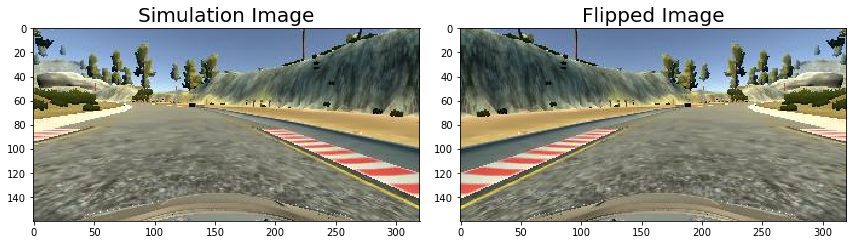

In [4]:
# The training set will be made up of the images / angles from the simulator
X_train = X_raw
y_train = y_raw

# Increase the amount of training data
# Flip the image and the sign of the angle and add it to the training set.
X_flip = np.empty(X_raw.shape,dtype=X_raw.dtype)
y_flip = np.empty(y_raw.shape,dtype=y_raw.dtype)

fig = plt.figure(num=1,figsize=(12,4))
i_fig = 20

for i in np.arange(len(y_raw)):
    X_flip[i] = cv2.flip(X_raw[i],1)
    y_flip[i] = -y_raw[i]

    if (i == i_fig):
        ax = fig.add_subplot(1,2,1)
        plt.imshow(X_raw[i])
        ax.set_title('Simulation Image', fontsize=20)
        
        ax = fig.add_subplot(1,2,2)
        plt.imshow(X_flip[i])
        ax.set_title('Flipped Image', fontsize=20)
        
        plt.tight_layout()        
        fig.savefig(os.path.join("flipped_image.jpg")) 
        
X_train = np.append(X_raw,X_flip,axis=0)
y_train = np.append(y_raw,y_flip)

print(X_train.shape,y_train.shape)

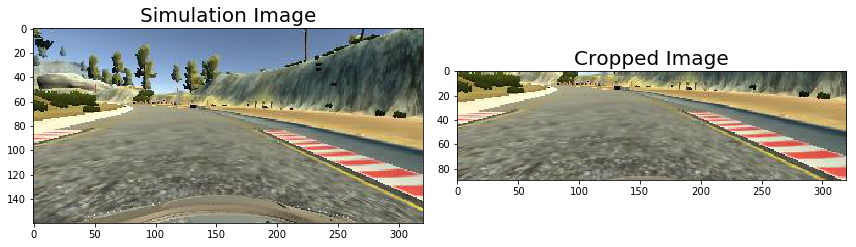

In [5]:
### show a cropped image. 
fig = plt.figure(num=1,figsize=(12,4))
i = 20

ax = fig.add_subplot(1,2,1)
plt.imshow(X_train[i])
ax.set_title('Simulation Image', fontsize=20)
        
cropped = X_train[i].copy()
cropped = cropped[0+50:160-20,:,:]

ax = fig.add_subplot(1,2,2)

plt.imshow(cropped)
ax.set_title('Cropped Image', fontsize=20)
        
plt.tight_layout()        
fig.savefig(os.path.join("cropped_image.jpg")) 


In [6]:
# lsq model in Keras
run_lsq = True
if (run_lsq):
    model = Sequential()
    
    model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160,320,3)))
    model.add(Lambda(lambda x: (x / 255.0) - 0.5))
    
    model.add(Flatten())
    model.add(Dense(1))

    #nb_epoch=5 is sufficient
    model.compile(loss='mse', optimizer='adam')
    hist = model.fit(X_train, y_train, validation_split=0.2, shuffle=True, 
                     nb_epoch=5, batch_size=512)

    print(hist.epoch)
    print(hist.history)

    model.save(os.path.join("model","model_lsq.h5"))

Train on 14576 samples, validate on 3644 samples
Epoch 1/5
14576/14576 [==============================] - 13s - loss: 1.6508 - val_loss: 0.4895
Epoch 2/5
14576/14576 [==============================] - 13s - loss: 0.1638 - val_loss: 0.1079
Epoch 3/5
14576/14576 [==============================] - 12s - loss: 0.0541 - val_loss: 0.0935
Epoch 4/5
14576/14576 [==============================] - 13s - loss: 0.0398 - val_loss: 0.0982
Epoch 5/5
14576/14576 [==============================] - 13s - loss: 0.0366 - val_loss: 0.0944
[0, 1, 2, 3, 4]
{'loss': [1.6508167990607043, 0.16379330194382452, 0.05414632148427314, 0.039785088016421555, 0.036624982912179277], 'val_loss': [0.48950136584586551, 0.10794474356260833, 0.093538869290922394, 0.098203788244632675, 0.09439830773159387]}


In [7]:
# lenet model with dropout in Keras
run_lenet = True
if (run_lenet):
    
    model = Sequential()
    model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160,320,3)))
    model.add(Lambda(lambda x: (x / 255.0) - 0.5))
    
    model.add(Convolution2D(6, 5, 5))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Convolution2D(16, 5, 5))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
        
    model.add(Flatten())
    model.add(Dense(120))
    model.add(Activation('relu'))
    model.add(Dense(84))
    model.add(Activation('relu'))
    model.add(Dense(1))

    #nb_epoch=10 is sufficient
    model.compile(loss='mse', optimizer='adam')
    hist = model.fit(X_train, y_train, validation_split=0.2, shuffle=True, 
                     nb_epoch=10, batch_size=256)
    print(hist.epoch)
    print(hist.history)
    
    model.save(os.path.join("model","model_lenet.h5"))
    

Train on 14576 samples, validate on 3644 samples
Epoch 1/10
14576/14576 [==============================] - 39s - loss: 0.1288 - val_loss: 0.0878
Epoch 2/10
14576/14576 [==============================] - 36s - loss: 0.0345 - val_loss: 0.0781
Epoch 3/10
14576/14576 [==============================] - 36s - loss: 0.0296 - val_loss: 0.0777
Epoch 4/10
14576/14576 [==============================] - 36s - loss: 0.0271 - val_loss: 0.0760
Epoch 5/10
14576/14576 [==============================] - 36s - loss: 0.0245 - val_loss: 0.0761
Epoch 6/10
14576/14576 [==============================] - 35s - loss: 0.0227 - val_loss: 0.0768
Epoch 7/10
14576/14576 [==============================] - 36s - loss: 0.0203 - val_loss: 0.0792
Epoch 8/10
14576/14576 [==============================] - 36s - loss: 0.0190 - val_loss: 0.0761
Epoch 9/10
14576/14576 [==============================] - 36s - loss: 0.0177 - val_loss: 0.0761
Epoch 10/10
14576/14576 [==============================] - 35s - loss: 0.0163 - val_los

In [8]:
# Nvidia's model in Keras
run_nvda=True
if (run_nvda):
 
    model = Sequential()
    
    model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160,320,3)))
    model.add(Lambda(lambda x: (x / 255.0) - 0.5)) 
    
    model.add(Convolution2D(24, 5, 5, subsample=(2,2)))
    model.add(Activation('relu'))
    
    model.add(Convolution2D(36, 5, 5, subsample=(2,2)))
    model.add(Activation('relu'))
        
    model.add(Convolution2D(48, 5, 5, subsample=(2,2)))
    model.add(Activation('relu'))
    
    model.add(Convolution2D(64, 3, 3))
    model.add(Activation('relu'))
    
    model.add(Convolution2D(64, 3, 3))
    model.add(Activation('relu'))
    
    model.add(Flatten())
    model.add(Dense(100))
    model.add(Activation('relu'))
    model.add(Dense(50))
    model.add(Activation('relu'))
    model.add(Dense(1))

    #nb_epoch=4, batch_size=256 is sufficient
    #nb_epoch=4, batch_size=128 is sufficient
    model.compile(loss='mse', optimizer='adam')
    hist = model.fit(X_train, y_train, validation_split=0.2, shuffle=True, 
                     nb_epoch=5, batch_size=256)

    model.summary()
    print(hist.epoch)
    print(hist.history)
    
    model.save(os.path.join("model","model_nvda.h5"))
    

Train on 14576 samples, validate on 3644 samples
Epoch 1/5
14576/14576 [==============================] - 40s - loss: 0.0354 - val_loss: 0.0632
Epoch 2/5
14576/14576 [==============================] - 35s - loss: 0.0306 - val_loss: 0.0605
Epoch 3/5
14576/14576 [==============================] - 35s - loss: 0.0293 - val_loss: 0.0610
Epoch 4/5
14576/14576 [==============================] - 35s - loss: 0.0282 - val_loss: 0.0628
Epoch 5/5
14576/14576 [==============================] - 35s - loss: 0.0260 - val_loss: 0.0636
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
cropping2d_3 (Cropping2D)        (None, 90, 320, 3)    0           cropping2d_input_3[0][0]         
____________________________________________________________________________________________________
lambda_3 (Lambda)                (None, 90, 320, 3)    0           cropp

In [27]:
# Nvidia's model with dropout in Keras
run_nvda_mod = True
dropout = 0.2
if (run_nvda_mod):
    model = Sequential()
    
    model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160,320,3)))
    model.add(Lambda(lambda x: (x / 255.0) - 0.5)) 
    
    #model.add(Convolution2D(24, 5, 5))
    model.add(Convolution2D(32, 5, 5))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(dropout))
    
    #model.add(Convolution2D(36, 5, 5))
    model.add(Convolution2D(32, 5, 5))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(dropout))
        
    model.add(Convolution2D(48, 4, 4))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(dropout))
    
    model.add(Convolution2D(64, 3, 3))
    model.add(Activation('relu'))
    model.add(Dropout(dropout))
    
    model.add(Convolution2D(64, 3, 3))
    model.add(Activation('relu'))
    
    model.add(Flatten())
    model.add(Dense(100))
    model.add(Activation('relu'))
    model.add(Dense(50))
    model.add(Activation('relu'))
    model.add(Dense(1))
    
    #nb_epoch=4, batch_size=128 is sufficient
    model.compile(loss='mse', optimizer='adam')
    hist = model.fit(X_train, y_train, validation_split=0.2, shuffle=True, 
                     nb_epoch=5, batch_size=128)

    model.summary()
    print(hist.epoch)
    print(hist.history)
    
    model.save(os.path.join("model","model_nvda_mod.h5"))
    

Train on 14576 samples, validate on 3644 samples
Epoch 1/5
14576/14576 [==============================] - 81s - loss: 0.0364 - val_loss: 0.0673
Epoch 2/5
14576/14576 [==============================] - 80s - loss: 0.0314 - val_loss: 0.0616
Epoch 3/5
14576/14576 [==============================] - 80s - loss: 0.0307 - val_loss: 0.0618
Epoch 4/5
14576/14576 [==============================] - 80s - loss: 0.0298 - val_loss: 0.0614
Epoch 5/5
14576/14576 [==============================] - 80s - loss: 0.0294 - val_loss: 0.0635
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
cropping2d_22 (Cropping2D)       (None, 90, 320, 3)    0           cropping2d_input_22[0][0]        
____________________________________________________________________________________________________
lambda_22 (Lambda)               (None, 90, 320, 3)    0           cropp

In [26]:
# Nvidia's model with dropout in Keras
run_nvda_mod2 = True
dropout = 0.2
if (run_nvda_mod2):
    model = Sequential()
    
    model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160,320,3)))
    model.add(Lambda(lambda x: (x / 255.0) - 0.5)) 
    
    #model.add(Convolution2D(24, 5, 5))
    model.add(Convolution2D(32, 5, 5, subsample=(2,2)))
    model.add(Activation('relu'))
    #model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(dropout))
    
    #model.add(Convolution2D(36, 5, 5))
    model.add(Convolution2D(32, 5, 5, subsample=(2,2)))
    model.add(Activation('relu'))
    #model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(dropout))
        
    model.add(Convolution2D(48, 4, 4, subsample=(2,2)))
    model.add(Activation('relu'))
    #model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(dropout))
    
    model.add(Convolution2D(64, 3, 3))
    model.add(Activation('relu'))
    model.add(Dropout(dropout))
    
    model.add(Convolution2D(64, 3, 3))
    model.add(Activation('relu'))
    
    model.add(Flatten())
    model.add(Dense(100))
    model.add(Activation('relu'))
    model.add(Dense(50))
    model.add(Activation('relu'))
    model.add(Dense(1))
    
    #nb_epoch=4, batch_size=128 is sufficient
    model.compile(loss='mse', optimizer='adam')
    hist = model.fit(X_train, y_train, validation_split=0.2, shuffle=True, 
                     nb_epoch=5, batch_size=128)

    model.summary()
    print(hist.epoch)
    print(hist.history)
    
    model.save(os.path.join("model","model_nvda_mod2.h5"))
    

Train on 14576 samples, validate on 3644 samples
Epoch 1/5
14576/14576 [==============================] - 40s - loss: 0.0372 - val_loss: 0.0705
Epoch 2/5
14576/14576 [==============================] - 39s - loss: 0.0321 - val_loss: 0.0684
Epoch 3/5
14576/14576 [==============================] - 39s - loss: 0.0312 - val_loss: 0.0627
Epoch 4/5
14576/14576 [==============================] - 39s - loss: 0.0297 - val_loss: 0.0613
Epoch 5/5
14576/14576 [==============================] - 39s - loss: 0.0292 - val_loss: 0.0669
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
cropping2d_21 (Cropping2D)       (None, 90, 320, 3)    0           cropping2d_input_21[0][0]        
____________________________________________________________________________________________________
lambda_21 (Lambda)               (None, 90, 320, 3)    0           cropp

In [10]:
# My model
run_vcnn = True
dropout = 0.2
if (run_vcnn):
    model = Sequential()
    
    #model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160,320,3)))
    model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160,320,3)))
    model.add(Lambda(lambda x: (x / 255.0) - 0.5)) 
    
    model.add(Convolution2D(36, 5, 9, subsample=(1,2)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(dropout))
    
    model.add(Convolution2D(48, 4, 7, subsample=(1,1)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(dropout))
    
    model.add(Convolution2D(60, 5, 5))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(dropout))
    
    model.add(Convolution2D(72, 3, 3))
    model.add(Activation('relu'))
    #model.add(MaxPooling2D((2, 2)))
    #model.add(Dropout(dropout))
    
    #model.add(Convolution2D(84, 3, 3))
    #model.add(Activation('relu'))
    
    model.add(Flatten())
    model.add(Dense(100))
    model.add(Activation('relu'))
    model.add(Dense(50))
    model.add(Activation('relu'))
    model.add(Dense(1))

    #nb_epoch=3-5, batch_size=256 is sufficient
    #nb_epoch=3-5, batch_size=128 is sufficient
    model.compile(loss='mse', optimizer='adam')
    hist = model.fit(X_train, y_train, validation_split=0.2, shuffle=True, 
                     nb_epoch=5, batch_size=128)

    model.summary()
    print(hist.epoch)
    print(hist.history)

    model.save(os.path.join("model","model_vcnn.h5"))

Train on 14576 samples, validate on 3644 samples
Epoch 1/5
14576/14576 [==============================] - 78s - loss: 0.0368 - val_loss: 0.0716
Epoch 2/5
14576/14576 [==============================] - 73s - loss: 0.0317 - val_loss: 0.0629
Epoch 3/5
14576/14576 [==============================] - 73s - loss: 0.0304 - val_loss: 0.0623
Epoch 4/5
14576/14576 [==============================] - 73s - loss: 0.0302 - val_loss: 0.0625
Epoch 5/5
14576/14576 [==============================] - 73s - loss: 0.0291 - val_loss: 0.0633
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
cropping2d_5 (Cropping2D)        (None, 90, 320, 3)    0           cropping2d_input_5[0][0]         
____________________________________________________________________________________________________
lambda_5 (Lambda)                (None, 90, 320, 3)    0           cropp

In [11]:
# My model
run_scnn = True
dropout = 0.2
if (run_scnn):
    model = Sequential()
    
    #model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160,320,3)))
    model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160,320,3)))
    model.add(Lambda(lambda x: (x / 255.0) - 0.5)) 
    
    #model.add(Convolution2D(36, 5, 9, subsample=(1,2)))
    model.add(Convolution2D(36, 5, 9, subsample=(1,1)))
    model.add(Activation('relu'))
    #model.add(MaxPooling2D((2, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(dropout))
    
    model.add(Convolution2D(48, 4, 7, subsample=(1,1)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(dropout))
    
    model.add(Convolution2D(60, 5, 5, subsample=(1,1)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(dropout))
    
    model.add(Convolution2D(72, 3, 3, subsample=(2,2)))
    #model.add(Convolution2D(72, 3, 3, subsample=(1,1)))
    model.add(Activation('relu'))
    #model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(dropout))
    
    #model.add(Convolution2D(84, 3, 3))
    #model.add(Activation('relu'))
    
    model.add(Flatten())
    model.add(Dense(200))
    model.add(Activation('relu'))
    model.add(Dense(50))
    model.add(Activation('relu'))
    model.add(Dense(1))

    #nb_epoch=3-5, batch_size=256 is sufficient
    #nb_epoch=3-5, batch_size=128 is sufficient
    model.compile(loss='mse', optimizer='adam')
    hist = model.fit(X_train, y_train, validation_split=0.2, shuffle=True, 
                     nb_epoch=5, batch_size=128)

    model.summary()
    print(hist.epoch)
    print(hist.history)

    model.save(os.path.join("model","model_scnn.h5"))

Train on 14576 samples, validate on 3644 samples
Epoch 1/5
14576/14576 [==============================] - 140s - loss: 0.0365 - val_loss: 0.0681
Epoch 2/5
14576/14576 [==============================] - 132s - loss: 0.0312 - val_loss: 0.0702
Epoch 3/5
14576/14576 [==============================] - 132s - loss: 0.0305 - val_loss: 0.0671
Epoch 4/5
14576/14576 [==============================] - 132s - loss: 0.0296 - val_loss: 0.0629
Epoch 5/5
14576/14576 [==============================] - 132s - loss: 0.0287 - val_loss: 0.0641
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
cropping2d_6 (Cropping2D)        (None, 90, 320, 3)    0           cropping2d_input_6[0][0]         
____________________________________________________________________________________________________
lambda_6 (Lambda)                (None, 90, 320, 3)    0           